In [42]:
%matplotlib inline

import hmm
import cma
from cma.fitness_transformations import EvalParallel2
from hidden_markov import hmm as hmm2
from matplotlib import pyplot as plt

import numpy as np

In [2]:
NUM_STATES = 2
NUM_SYMBOLS = 2

true_x = NUM_STATES
true_x2 = ('0', '1')
true_y = np.array(['a', 'b'])
true_y2 = ('a', 'b')
true_a = np.array([
    [0.5, 0.5],
    [0.7, 0.3]
])
true_b = np.array([
    [0.2, 0.8],
    [0.8, 0.2]
])
true_s = np.array([1.0, 0.0])

true_hmm = hmm.HMM(
    true_x,
    true_y,
    true_a,
    true_b,
    true_s
)

true_hmm2 = hmm2(
    true_x2,
    true_y2,
    np.matrix(true_s),
    np.matrix(true_a),
    np.matrix(true_b)
)

In [3]:
list(true_hmm.simulate(10, reset_before=True))

[array([0, 1, 0, 0, 0, 1, 1, 0, 0, 1]),
 array(['b', 'a', 'b', 'a', 'b', 'a', 'a', 'b', 'b', 'a'], dtype='<U1')]

In [4]:
# Transform genotype to phenotype
# 1D array -> (2D array, 2D array)
def geno_to_pheno(geno):
    assert len(geno) == NUM_STATES ** 2 + NUM_STATES * NUM_SYMBOLS
#     print(f"Geno -> Pheno for:\n{geno}")
    # Extract the transition and emission matrices from the genotype
    trans_mat = geno[:NUM_STATES ** 2].copy().reshape((NUM_STATES, NUM_STATES))
    emiss_mat = geno[NUM_STATES ** 2:].copy().reshape((NUM_STATES, NUM_SYMBOLS))
    # Take element-wise absolute value
    trans_mat = np.absolute(trans_mat)
    emiss_mat = np.absolute(emiss_mat)
    # Normalise rows to sum to 1
    trans_mat = trans_mat / trans_mat.sum(axis=1, keepdims=True)
    emiss_mat = emiss_mat / emiss_mat.sum(axis=1, keepdims=True)
#     print(f"Transition Matrix:\n{trans_mat}")
#     print(f"Emission Matrix:\n{emiss_mat}")
    return (trans_mat, emiss_mat)
    
# Transform phenotype to genotype
# (2D array, 2D array) -> 1D array
def pheno_to_geno(pheno):
    (trans_mat, emiss_mat) = pheno
    assert trans_mat.shape == (NUM_STATES, NUM_STATES)
    assert emiss_mat.shape == (NUM_STATES, NUM_SYMBOLS)
    print(f"Pheno -> Geno for:\n{pheno}")
    geno = np.concatenate((
        trans_mat.copy().reshape(-1),
        emiss_mat.copy().reshape(-1)
    ))
    print(f"Genotype:\n{geno}")
    return geno

In [5]:
t = np.arange(8)
np.array_equal(t, pheno_to_geno(geno_to_pheno(t)))

Pheno -> Geno for:
(array([[0. , 1. ],
       [0.4, 0.6]]), array([[0.44444444, 0.55555556],
       [0.46153846, 0.53846154]]))
Genotype:
[0.         1.         0.4        0.6        0.44444444 0.55555556
 0.46153846 0.53846154]


False

In [9]:
def obj_fun(sol):
    (trans_mat, emiss_mat) = geno_to_pheno(sol)
    sol_hmm = hmm.HMM(
        true_x,
        true_y,
        trans_mat,
        emiss_mat,
        true_s
    )
    seq_len = 50
    samples = 20
    mses = np.zeros(samples)
    
    for i in range(samples):
        _, sol_seq = sol_hmm.simulate(seq_len, reset_before=True)
        _, true_seq = true_hmm.simulate(seq_len, reset_before=True)

        _, sol_seq_counts = np.unique(sol_seq, return_counts=True)
        _, true_seq_counts = np.unique(true_seq, return_counts=True)
#         print(sol_seq_counts)
#         print(true_seq_counts)

        mse = (np.square(np.subtract(sol_seq_counts, true_seq_counts))).mean() / seq_len
        mses[i] = mse
    
    fitness = mses.mean()
    print(f'Fitness: {fitness}')
    
    return fitness

In [7]:
init_sol = np.full(NUM_STATES ** 2 + NUM_STATES * NUM_SYMBOLS, 0.5)
print(init_sol)
es = cma.CMAEvolutionStrategy(init_sol, 0.2)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=278822, Sat Nov 30 18:01:08 2019)


In [8]:
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [obj_fun(x) for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()

Fitness: 9.659
Fitness: 1.8809999999999998
Fitness: 10.372499999999999
Fitness: 5.8885000000000005
Fitness: 0.5139999999999999
Fitness: 1.1809999999999996
Fitness: 0.9615
Fitness: 0.7224999999999999
Fitness: 0.6565000000000001
Fitness: 4.646
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 5.139999999999999e-01 1.0e+00 1.85e-01  2e-01  2e-01 0:01.9
Fitness: 0.5780000000000001
Fitness: 3.0930000000000004
Fitness: 1.131
Fitness: 1.329
Fitness: 3.653
Fitness: 3.1610000000000005
Fitness: 1.0325
Fitness: 0.4145
Fitness: 0.6194999999999999
Fitness: 2.1109999999999998
    2     20 4.145000000000000e-01 1.2e+00 1.86e-01  2e-01  2e-01 0:03.8
Fitness: 2.164
Fitness: 6.455
Fitness: 1.6509999999999998
Fitness: 1.038
Fitness: 0.5445
Fitness: 0.7765
Fitness: 1.4659999999999997
Fitness: 0.5075000000000001
Fitness: 0.959
Fitness: 1.2100000000000002
    3     30 5.075000000000001e-01 1.3e+00 1.94e-01  2e-01  2e-01 0:05.8
Fitness: 0.42750000000000005
Fitness: 0.786
Fi

Fitness: 0.23450000000000001
Fitness: 0.394
Fitness: 0.21799999999999997
Fitness: 0.3045
Fitness: 0.8945000000000001
Fitness: 0.5090000000000001
Fitness: 0.368
Fitness: 0.4095
Fitness: 0.3645
Fitness: 0.5225
Fitness: 0.6004999999999999
Fitness: 0.5115000000000001
Fitness: 0.7995000000000001
Fitness: 0.36449999999999994
Fitness: 0.3185
Fitness: 0.26599999999999996
Fitness: 0.313
Fitness: 0.8414999999999999
Fitness: 0.6365000000000001
Fitness: 0.4535
Fitness: 0.7335
Fitness: 0.32899999999999996
Fitness: 0.6130000000000001
Fitness: 0.7815000000000001
Fitness: 0.502
Fitness: 0.4495
Fitness: 0.6319999999999999
Fitness: 0.5000000000000001
Fitness: 0.7114999999999998
Fitness: 0.44749999999999995
Fitness: 0.34199999999999997
Fitness: 0.2985
Fitness: 0.403
Fitness: 0.5485
Fitness: 0.4185
Fitness: 0.7579999999999999
Fitness: 0.2935
Fitness: 0.6184999999999999
Fitness: 0.6900000000000001
Fitness: 0.7035
Fitness: 0.33799999999999997
Fitness: 0.7935
Fitness: 0.579
Fitness: 0.352
Fitness: 0.42449999

Fitness: 0.47350000000000003
Fitness: 0.5674999999999999
   71    710 4.734999999999999e-01 7.8e+00 8.10e-02  4e-02  1e-01 2:16.6
Fitness: 0.319
Fitness: 0.5960000000000001
Fitness: 0.356
Fitness: 0.63
Fitness: 0.5635
Fitness: 0.5774999999999999
Fitness: 0.6739999999999999
Fitness: 0.37899999999999995
Fitness: 0.438
Fitness: 1.052
Fitness: 0.41899999999999993
Fitness: 0.502
Fitness: 0.44299999999999995
Fitness: 0.257
Fitness: 0.5049999999999999
Fitness: 0.46099999999999997
Fitness: 0.43950000000000006
Fitness: 0.48999999999999994
Fitness: 0.483
Fitness: 0.7615000000000001
Fitness: 0.48299999999999993
Fitness: 0.47450000000000003
Fitness: 0.7649999999999999
Fitness: 0.3365
Fitness: 0.40750000000000003
Fitness: 0.8675
Fitness: 0.43100000000000005
Fitness: 1.7099999999999997
Fitness: 0.648
Fitness: 0.6844999999999999
Fitness: 0.819
Fitness: 1.1435
Fitness: 0.616
Fitness: 1.0474999999999999
Fitness: 0.689
Fitness: 0.4755
Fitness: 0.9025000000000002
Fitness: 0.5245
Fitness: 0.70049999999999

Fitness: 1.0534999999999999
Fitness: 0.5850000000000001
Fitness: 0.6539999999999999
Fitness: 0.382
Fitness: 0.304
Fitness: 0.351
Fitness: 0.7785
Fitness: 0.8320000000000001
Fitness: 0.642
Fitness: 0.6355000000000001
Fitness: 0.6335
Fitness: 0.373
Fitness: 0.391
Fitness: 0.6715
Fitness: 0.42399999999999993
Fitness: 0.7135
Fitness: 0.5670000000000001
Fitness: 0.2305
Fitness: 0.34650000000000003
Fitness: 0.38149999999999995
Fitness: 0.5715
Fitness: 0.394
Fitness: 0.39849999999999997
Fitness: 0.39399999999999996
Fitness: 1.2184999999999997
Fitness: 0.8595
Fitness: 0.41150000000000003
Fitness: 0.8205
Fitness: 0.8695
Fitness: 0.7609999999999999
Fitness: 0.39599999999999996
Fitness: 1.0895
Fitness: 0.8234999999999999
Fitness: 0.4995
Fitness: 0.4725
Fitness: 0.3905
Fitness: 0.99
Fitness: 0.5885
Fitness: 0.9149999999999998
Fitness: 0.3265
Fitness: 0.38049999999999995
Fitness: 0.5389999999999999
Fitness: 0.472
Fitness: 0.7969999999999999
Fitness: 0.4165
Fitness: 0.47000000000000003
  111   1110 

Fitness: 0.3235
Fitness: 0.5930000000000001
Fitness: 0.496
Fitness: 0.759
Fitness: 0.9954999999999998
Fitness: 0.3955
Fitness: 0.5035000000000001
Fitness: 0.331
Fitness: 0.5865
Fitness: 0.745
Fitness: 0.6385
Fitness: 0.511
Fitness: 0.24849999999999994
Fitness: 0.5245
Fitness: 0.477
Fitness: 0.5145
Fitness: 0.49499999999999994
Fitness: 0.3805
Fitness: 0.5654999999999999
Fitness: 0.42000000000000004
Fitness: 0.22600000000000003
Fitness: 0.5559999999999999
Fitness: 0.5199999999999999
Fitness: 0.5405
Fitness: 0.38850000000000007
Fitness: 0.48649999999999993
Fitness: 0.41400000000000003
Fitness: 0.6269999999999999
Fitness: 0.409
Fitness: 0.37950000000000006
Fitness: 0.45099999999999996
  147   1470 3.795000000000001e-01 1.9e+01 5.72e-02  2e-02  7e-02 4:41.9
Fitness: 0.39249999999999996
Fitness: 0.4584999999999999
Fitness: 0.3215
Fitness: 0.5805
Fitness: 0.48250000000000004
Fitness: 0.2775
Fitness: 0.5645
Fitness: 0.7189999999999999
Fitness: 0.8634999999999999
Fitness: 0.26149999999999995
Fi

Fitness: 0.466
Fitness: 0.6815
Fitness: 0.48250000000000004
Fitness: 0.6209999999999999
Fitness: 0.38100000000000006
Fitness: 0.44799999999999995
Fitness: 0.49850000000000005
Fitness: 0.2795
Fitness: 0.31399999999999995
Fitness: 0.264
Fitness: 0.25599999999999995
Fitness: 0.41500000000000004
Fitness: 0.579
Fitness: 0.3355
Fitness: 0.32399999999999995
Fitness: 0.36849999999999994
Fitness: 0.7615000000000001
Fitness: 0.40099999999999997
Fitness: 0.2865
Fitness: 0.37950000000000006
Fitness: 0.40199999999999997
Fitness: 0.29050000000000004
Fitness: 0.71
Fitness: 0.2925
Fitness: 0.38249999999999995
Fitness: 0.38
Fitness: 0.4965
Fitness: 0.7895
Fitness: 0.5315
Fitness: 0.5295
Fitness: 0.10149999999999999
Fitness: 0.716
  185   1850 1.015000000000000e-01 3.3e+01 8.53e-02  2e-02  1e-01 5:59.3
Fitness: 0.4069999999999999
Fitness: 0.8225
Fitness: 0.484
Fitness: 0.3954999999999999
Fitness: 0.34049999999999997
Fitness: 0.5795
Fitness: 0.462
Fitness: 0.39799999999999996
Fitness: 0.39649999999999996

Fitness: 0.6789999999999999
Fitness: 0.8389999999999999
Fitness: 0.331
Fitness: 0.418
Fitness: 0.40549999999999997
Fitness: 0.7255
Fitness: 0.6435000000000001
Fitness: 0.521
Fitness: 0.27999999999999997
Fitness: 0.298
Fitness: 0.30650000000000005
Fitness: 0.5915
Fitness: 0.7215
Fitness: 0.6495
Fitness: 0.7565000000000001
Fitness: 0.27649999999999997
Fitness: 0.679
Fitness: 0.273
Fitness: 0.5589999999999999
Fitness: 0.9030000000000001
Fitness: 0.38849999999999996
Fitness: 0.29300000000000004
Fitness: 0.36900000000000005
Fitness: 0.2655
Fitness: 0.5389999999999999
Fitness: 0.44899999999999995
Fitness: 0.4424999999999999
Fitness: 0.4734999999999999
Fitness: 0.623
Fitness: 0.458
Fitness: 0.6525000000000001
Fitness: 0.3225
Fitness: 0.515
Fitness: 0.5455
Fitness: 0.3105
Fitness: 0.501
Fitness: 0.544
Fitness: 0.5239999999999998
Fitness: 0.36099999999999993
Fitness: 0.663
Fitness: 0.36
Fitness: 0.2495
Fitness: 0.32399999999999995
Fitness: 0.32100000000000006
Fitness: 0.4674999999999999
Fitness

Fitness: 0.207
Fitness: 0.4805
Fitness: 0.619
Fitness: 0.4665
Fitness: 0.6454999999999999
Fitness: 0.475
Fitness: 0.7975
Fitness: 0.5200000000000001
Fitness: 0.4305
  256   2560 2.070000000000000e-01 3.2e+01 3.97e-02  9e-03  5e-02 8:36.2
Fitness: 0.23349999999999999
Fitness: 0.5534999999999999
Fitness: 0.7325
Fitness: 0.6004999999999999
Fitness: 0.2695
Fitness: 0.5174999999999998
Fitness: 1.2105
Fitness: 0.372
Fitness: 0.3665
Fitness: 0.4885
Fitness: 0.421
Fitness: 0.5605
Fitness: 0.7464999999999999
Fitness: 0.483
Fitness: 0.5389999999999999
Fitness: 0.37700000000000006
Fitness: 0.286
Fitness: 0.7055
Fitness: 0.6059999999999999
Fitness: 0.34349999999999997
Fitness: 0.29700000000000004
Fitness: 0.9120000000000001
Fitness: 0.286
Fitness: 0.43199999999999983
Fitness: 0.5965
Fitness: 0.893
Fitness: 0.3855
Fitness: 0.5585
Fitness: 0.5589999999999999
Fitness: 0.4185
Fitness: 0.649
Fitness: 0.38899999999999996
Fitness: 0.46849999999999986
Fitness: 0.45899999999999996
Fitness: 0.45149999999999

Fitness: 0.7635000000000001
Fitness: 0.45649999999999996
Fitness: 0.304
Fitness: 0.49099999999999994
Fitness: 0.45600000000000007
Fitness: 0.391
Fitness: 0.5759999999999998
Fitness: 0.31
Fitness: 0.5025
Fitness: 0.38150000000000006
Fitness: 0.2205
Fitness: 0.5039999999999999
Fitness: 0.4924999999999999
Fitness: 0.5785
Fitness: 0.31149999999999994
Fitness: 0.41550000000000004
Fitness: 0.39999999999999997
Fitness: 0.47850000000000004
Fitness: 0.4774999999999999
Fitness: 0.541
Fitness: 0.6635000000000001
Fitness: 0.808
Fitness: 0.3495
Fitness: 0.472
Fitness: 0.3135
Fitness: 0.40700000000000003
Fitness: 0.4265
Fitness: 0.462
Fitness: 0.5734999999999999
Fitness: 0.6015
Fitness: 0.7000000000000001
Fitness: 0.311
Fitness: 0.4
Fitness: 0.27699999999999997
Fitness: 0.256
Fitness: 0.3605
Fitness: 0.3835
Fitness: 0.48599999999999993
Fitness: 0.596
Fitness: 0.7494999999999999
Fitness: 0.671
Fitness: 0.5409999999999999
Fitness: 0.5105
Fitness: 0.426
Fitness: 0.5245
Fitness: 0.49050000000000005
Fitn

Fitness: 0.4295
Fitness: 0.37
Fitness: 0.40650000000000003
Fitness: 0.5915
Fitness: 0.374
Fitness: 0.402
Fitness: 0.39949999999999997
Fitness: 0.40800000000000003
Fitness: 0.3135
Fitness: 0.3535
Fitness: 0.4185
Fitness: 0.5495000000000001
Fitness: 0.4165000000000001
Fitness: 0.37
Fitness: 0.38100000000000006
Fitness: 0.4504999999999999
Fitness: 0.2995
Fitness: 0.5485
Fitness: 0.44349999999999995
Fitness: 0.48200000000000004
Fitness: 0.5545
Fitness: 0.37700000000000006
Fitness: 0.29799999999999993
Fitness: 0.5445
Fitness: 0.4495000000000001
Fitness: 0.7525
Fitness: 0.26599999999999996
Fitness: 0.47050000000000003
Fitness: 0.44449999999999995
Fitness: 0.4265
Fitness: 0.675
Fitness: 0.35450000000000004
Fitness: 0.43500000000000005
Fitness: 0.7409999999999999
Fitness: 0.616
Fitness: 0.596
Fitness: 0.7074999999999999
Fitness: 0.37549999999999994
Fitness: 0.274
Fitness: 0.48
Fitness: 0.5589999999999999
Fitness: 0.6164999999999999
Fitness: 0.31800000000000006
Fitness: 0.4565
Fitness: 0.728
Fi

Fitness: 0.7605
Fitness: 0.672
Fitness: 0.3225
Fitness: 0.236
Fitness: 0.4135
Fitness: 0.3825
Fitness: 0.35900000000000004
Fitness: 0.4739999999999999
Fitness: 0.473
Fitness: 0.641
Fitness: 0.3015
Fitness: 0.413
Fitness: 0.41550000000000004
Fitness: 0.33299999999999996
Fitness: 0.4885
Fitness: 0.44899999999999995
Fitness: 0.6045
Fitness: 0.46749999999999997
Fitness: 0.24450000000000002
Fitness: 0.485
Fitness: 0.546
Fitness: 0.712
Fitness: 0.527
Fitness: 0.36750000000000005
Fitness: 0.365
Fitness: 0.3235
Fitness: 0.4149999999999999
Fitness: 0.6125
Fitness: 0.603
Fitness: 0.4255
Fitness: 0.6014999999999999
Fitness: 0.29050000000000004
Fitness: 0.565
Fitness: 0.328
Fitness: 0.44799999999999995
Fitness: 0.321
Fitness: 0.42349999999999993
Fitness: 0.36150000000000004
Fitness: 0.38049999999999995
Fitness: 0.732
Fitness: 0.5224999999999999
Fitness: 0.6425
Fitness: 0.85
Fitness: 0.363
Fitness: 0.5604999999999999
Fitness: 0.6849999999999999
Fitness: 0.6885
Fitness: 0.41899999999999993
Fitness: 

Fitness: 0.3295
Fitness: 0.649
Fitness: 0.39349999999999996
Fitness: 0.538
Fitness: 0.2815
Fitness: 0.514
Fitness: 0.303
Fitness: 0.5905
Fitness: 0.4734999999999999
Fitness: 0.7275
Fitness: 0.2985
Fitness: 0.5239999999999999
Fitness: 0.6379999999999999
Fitness: 0.47750000000000004
Fitness: 0.21749999999999997
Fitness: 0.2875
Fitness: 0.9039999999999999
Fitness: 0.4725
Fitness: 0.425
Fitness: 0.491
Fitness: 0.44299999999999995
Fitness: 0.8084999999999999
Fitness: 0.8394999999999999
Fitness: 0.374
Fitness: 0.1575
Fitness: 0.5715
Fitness: 0.311
Fitness: 0.845
Fitness: 0.374
Fitness: 0.4485
Fitness: 0.42499999999999993
Fitness: 0.28500000000000003
Fitness: 0.696
Fitness: 0.368
Fitness: 0.7675
Fitness: 0.39849999999999997
Fitness: 0.8735000000000002
Fitness: 0.631
Fitness: 0.4845
Fitness: 0.6645
Fitness: 0.24400000000000005
Fitness: 0.2945
Fitness: 0.43949999999999995
Fitness: 0.4459999999999999
Fitness: 0.43500000000000005
Fitness: 0.3285
Fitness: 0.34750000000000003
Fitness: 0.316
Fitness

Fitness: 0.6975
Fitness: 0.5095
Fitness: 0.3344999999999999
Fitness: 0.44749999999999995
Fitness: 0.5980000000000001
Fitness: 0.5774999999999999
Fitness: 0.6994999999999999
Fitness: 0.3635
Fitness: 0.5085
Fitness: 0.3
Fitness: 0.46449999999999997
Fitness: 0.5214999999999999
Fitness: 0.404
Fitness: 0.45500000000000007
Fitness: 0.5519999999999998
Fitness: 0.37299999999999994
Fitness: 0.4754999999999999
Fitness: 0.4624999999999999
Fitness: 0.446
Fitness: 0.344
Fitness: 0.2685
Fitness: 0.4584999999999999
Fitness: 0.347
Fitness: 0.605
  445   4450 2.685000000000000e-01 2.7e+02 1.25e-02  2e-03  2e-02 14:40.2
Fitness: 0.4575
Fitness: 0.6505000000000001
Fitness: 0.264
Fitness: 0.7255
Fitness: 0.302
Fitness: 0.30649999999999994
Fitness: 0.43499999999999994
Fitness: 0.319
Fitness: 0.39499999999999996
Fitness: 0.6239999999999999
Fitness: 0.38499999999999995
Fitness: 0.3315
Fitness: 0.3885
Fitness: 0.3945
Fitness: 0.43550000000000005
Fitness: 0.6545
Fitness: 0.509
Fitness: 0.28650000000000003
Fitn

Fitness: 0.49450000000000005
Fitness: 0.4305
Fitness: 0.5005
Fitness: 0.366
Fitness: 0.6649999999999999
Fitness: 0.4760000000000001
Fitness: 0.25550000000000006
Fitness: 0.684
Fitness: 0.5974999999999999
Fitness: 0.4575
Fitness: 0.472
Fitness: 0.44400000000000006
Fitness: 0.33199999999999996
Fitness: 0.471
Fitness: 0.5475000000000001
Fitness: 0.45999999999999996
Fitness: 0.531
Fitness: 0.31050000000000005
Fitness: 0.48949999999999994
Fitness: 0.8089999999999999
Fitness: 0.3165
Fitness: 0.27749999999999997
Fitness: 0.6174999999999999
Fitness: 0.3475
Fitness: 0.302
Fitness: 0.663
Fitness: 0.5534999999999999
Fitness: 0.588
Fitness: 0.4805
Fitness: 0.5475
Fitness: 0.4095
Fitness: 0.8174999999999999
Fitness: 0.5974999999999999
Fitness: 0.33999999999999997
Fitness: 0.5359999999999999
Fitness: 0.3685
Fitness: 0.402
Fitness: 0.38749999999999996
Fitness: 0.5269999999999999
Fitness: 0.52
Fitness: 0.2615
Fitness: 0.6924999999999999
Fitness: 0.539
Fitness: 0.7604999999999998
Fitness: 0.27599999999

Fitness: 0.33399999999999996
Fitness: 0.434
Fitness: 0.3115
Fitness: 0.26649999999999996
Fitness: 0.3305
Fitness: 0.5635
Fitness: 0.48199999999999993
Fitness: 0.5585
Fitness: 0.5394999999999999
Fitness: 0.719
Fitness: 0.741
Fitness: 0.6024999999999999
Fitness: 0.358
Fitness: 0.659
Fitness: 0.3595
Fitness: 0.4630000000000001
Fitness: 0.9389999999999998
Fitness: 0.645
Fitness: 0.533
Fitness: 0.4165
Fitness: 0.3135
Fitness: 0.37900000000000006
Fitness: 0.35300000000000004
Fitness: 0.561
Fitness: 0.6069999999999999
Fitness: 0.3135
Fitness: 0.5875
Fitness: 0.5075000000000001
Fitness: 0.5754999999999999
Fitness: 0.35500000000000004
Fitness: 0.6045
Fitness: 0.5115
Fitness: 0.3595
Fitness: 0.18849999999999997
Fitness: 0.44650000000000006
Fitness: 0.5415
Fitness: 0.27399999999999997
Fitness: 0.484
Fitness: 0.362
Fitness: 0.489
Fitness: 0.16349999999999998
Fitness: 0.4525
Fitness: 0.43600000000000005
Fitness: 0.6185
Fitness: 0.7925000000000001
Fitness: 0.36649999999999994
Fitness: 0.7635
Fitness

Fitness: 0.3425
Fitness: 0.5955
Fitness: 0.7015
Fitness: 0.3835
Fitness: 0.271
Fitness: 0.5079999999999999
Fitness: 0.457
Fitness: 0.26450000000000007
Fitness: 0.551
Fitness: 0.3275
Fitness: 0.4885
Fitness: 0.4584999999999999
Fitness: 0.4175000000000001
Fitness: 0.4754999999999999
Fitness: 0.5245
Fitness: 0.595
Fitness: 0.4974999999999999
Fitness: 0.5345
Fitness: 0.381
Fitness: 0.5245
Fitness: 0.5314999999999999
Fitness: 0.6064999999999999
Fitness: 0.8775000000000001
Fitness: 0.184
Fitness: 0.319
Fitness: 0.394
Fitness: 0.709
Fitness: 0.37149999999999994
Fitness: 0.4374999999999999
Fitness: 0.54
Fitness: 0.7055
Fitness: 0.417
Fitness: 0.488
Fitness: 0.197
Fitness: 0.701
Fitness: 0.4285
Fitness: 0.1905
Fitness: 0.269
Fitness: 0.284
Fitness: 0.56
Fitness: 0.7089999999999999
Fitness: 0.617
Fitness: 0.6005
Fitness: 0.5449999999999999
Fitness: 0.366
Fitness: 0.577
Fitness: 0.38799999999999996
Fitness: 0.48599999999999993
Fitness: 0.37849999999999995
Fitness: 0.5569999999999999
Fitness: 0.78

Fitness: 0.5315
Fitness: 0.38950000000000007
Fitness: 0.6119999999999999
Fitness: 0.597
Fitness: 0.6725000000000001
Fitness: 0.41550000000000004
Fitness: 0.20600000000000002
Fitness: 0.37149999999999994
Fitness: 0.32799999999999996
Fitness: 0.36
Fitness: 0.6405000000000001
Fitness: 0.38499999999999995
Fitness: 0.5800000000000001
Fitness: 0.27
Fitness: 0.4305
Fitness: 0.636
Fitness: 0.382
Fitness: 0.45599999999999996
Fitness: 0.6425000000000001
Fitness: 0.36400000000000005
Fitness: 0.45599999999999996
Fitness: 0.28900000000000003
Fitness: 0.2545
Fitness: 0.14749999999999996
Fitness: 0.488
Fitness: 0.8
Fitness: 0.6674999999999999
Fitness: 0.5015
Fitness: 0.42899999999999994
Fitness: 0.5365
Fitness: 0.5559999999999999
Fitness: 0.42700000000000005
Fitness: 0.4205
Fitness: 0.327
Fitness: 0.8654999999999999
Fitness: 0.529
Fitness: 0.8879999999999999
Fitness: 0.6605
Fitness: 0.4065
Fitness: 0.5534999999999999
Fitness: 0.496
Fitness: 0.483
Fitness: 0.4109999999999999
Fitness: 0.404499999999999

Fitness: 0.48250000000000004
Fitness: 0.44749999999999995
Fitness: 0.29
Fitness: 0.40249999999999997
Fitness: 0.392
Fitness: 0.37099999999999994
  627   6270 2.360000000000000e-01 7.6e+02 5.06e-03  3e-04  2e-03 20:28.2
Fitness: 0.1875
Fitness: 0.6824999999999999
Fitness: 0.43900000000000006
Fitness: 0.34
Fitness: 0.49450000000000005
Fitness: 0.7985
Fitness: 0.5775
Fitness: 0.909
Fitness: 0.29900000000000004
Fitness: 0.38899999999999996
Fitness: 0.385
Fitness: 0.471
Fitness: 0.7539999999999999
Fitness: 0.45099999999999996
Fitness: 0.605
Fitness: 0.4165
Fitness: 0.5055
Fitness: 0.374
Fitness: 0.6125
Fitness: 0.5605
Fitness: 0.471
Fitness: 0.26149999999999995
Fitness: 0.5735
Fitness: 0.174
Fitness: 0.5345
Fitness: 0.5594999999999999
Fitness: 0.4464999999999999
Fitness: 0.6495
Fitness: 0.708
Fitness: 0.6085
  630   6300 1.740000000000000e-01 7.7e+02 4.83e-03  3e-04  2e-03 20:33.7


In [10]:
for x in solutions:
    t, e = geno_to_pheno(x)
    print(f'Transmission Matrix:\n{t}')
    print(f'Emission Matrix:\n{e}\n')

Transmission Matrix:
[[0.29260439 0.70739561]
 [0.36757781 0.63242219]]
Emission Matrix:
[[0.34538635 0.65461365]
 [0.4934168  0.5065832 ]]

Transmission Matrix:
[[0.29606262 0.70393738]
 [0.36717887 0.63282113]]
Emission Matrix:
[[0.34505311 0.65494689]
 [0.49357326 0.50642674]]

Transmission Matrix:
[[0.29460555 0.70539445]
 [0.36896114 0.63103886]]
Emission Matrix:
[[0.34498538 0.65501462]
 [0.49353079 0.50646921]]

Transmission Matrix:
[[0.29512367 0.70487633]
 [0.36785371 0.63214629]]
Emission Matrix:
[[0.34506267 0.65493733]
 [0.49352361 0.50647639]]

Transmission Matrix:
[[0.29396816 0.70603184]
 [0.36801234 0.63198766]]
Emission Matrix:
[[0.34512565 0.65487435]
 [0.49354447 0.50645553]]

Transmission Matrix:
[[0.29255993 0.70744007]
 [0.36797569 0.63202431]]
Emission Matrix:
[[0.3452817  0.6547183 ]
 [0.49351066 0.50648934]]

Transmission Matrix:
[[0.29423521 0.70576479]
 [0.36770427 0.63229573]]
Emission Matrix:
[[0.34496338 0.65503662]
 [0.4937547  0.5062453 ]]

Transmission 

In [11]:
es.result_pretty()

termination on tolstagnation=326
final/bestever f-value = 1.740000e-01 1.015000e-01
incumbent solution: [0.3656270110845351, 0.8738315376462591, 0.28701794297107375, 0.4937124145734827, 0.6380240901078923, 1.2109289493487314, 0.634938267009628, 0.6514921070352087]
std deviation: [0.0023625146537790648, 0.00226652288189264, 0.0008370613777304122, 0.0008683578019763613, 0.000713029621732564, 0.0007501982625000824, 0.00044071310662074036, 0.00030253972920438806]


CMAEvolutionStrategyResult(xbest=array([0.36550209, 0.67202806, 0.24174183, 0.4071625 , 0.61733586,
       1.29049277, 0.62980136, 0.59547289]), fbest=0.10149999999999999, evals_best=1849, evaluations=6300, iterations=630, xfavorite=array([0.36562701, 0.87383154, 0.28701794, 0.49371241, 0.63802409,
       1.21092895, 0.63493827, 0.65149211]), stds=array([0.00236251, 0.00226652, 0.00083706, 0.00086836, 0.00071303,
       0.0007502 , 0.00044071, 0.00030254]), stop={'tolstagnation': 326})

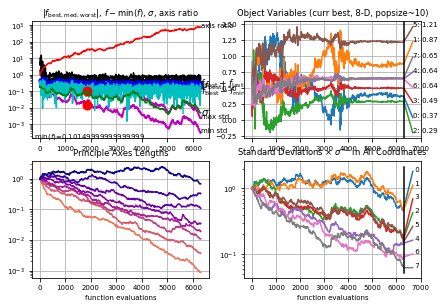

In [12]:
es.logger.plot()

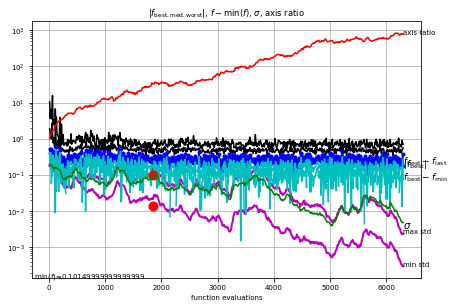

In [13]:
es.logger.plot_divers()

In [63]:
idxs = es.logger.data['f'][:, 0]
idxs = idxs.astype(int)

bestever = es.logger.data['f'][:, 4]
best = es.logger.data['f'][:, 5]

print(idxs[:10])
print(bestever[:10])

[ 1  2  3  4  5  6  7  8  9 10]
[0.514  0.4145 0.4145 0.231  0.231  0.231  0.231  0.231  0.231  0.231 ]


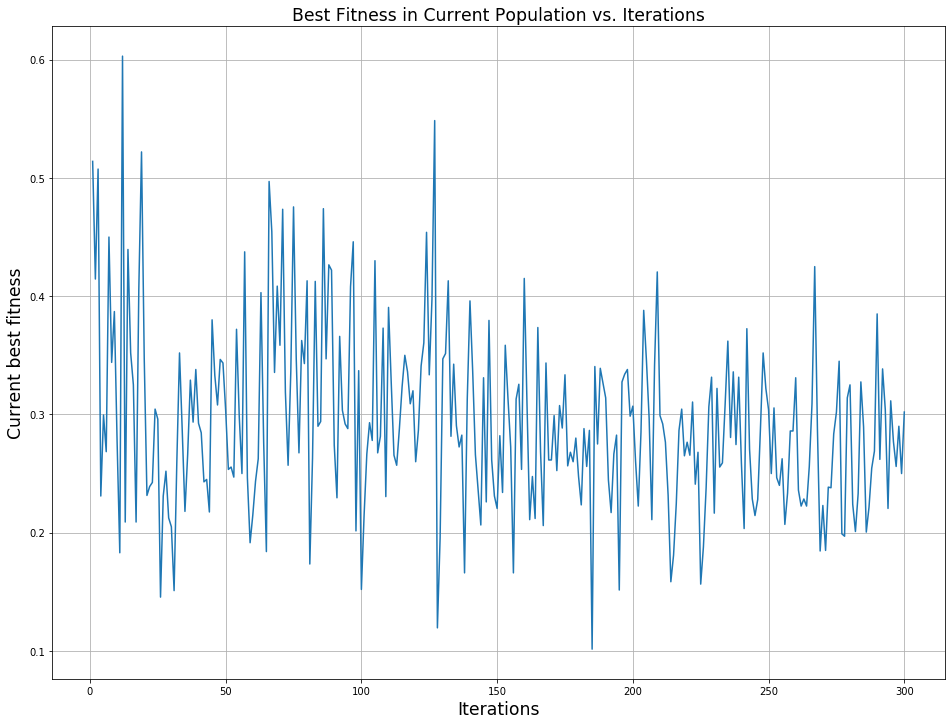

In [104]:
# Plot current best objective function value against iterations
fs = 'xx-large'

plt.figure(figsize=(16, 12))
plt.title('Best Fitness in Current Population vs. Iterations', fontsize=fs)
plt.xlabel('Iterations', fontsize=fs)
plt.ylabel('Current best fitness', fontsize=fs)
plt.plot(idxs[:300], best[:300])
plt.grid()
plt.savefig('./current_best_fitness_iterations.png')
plt.show()

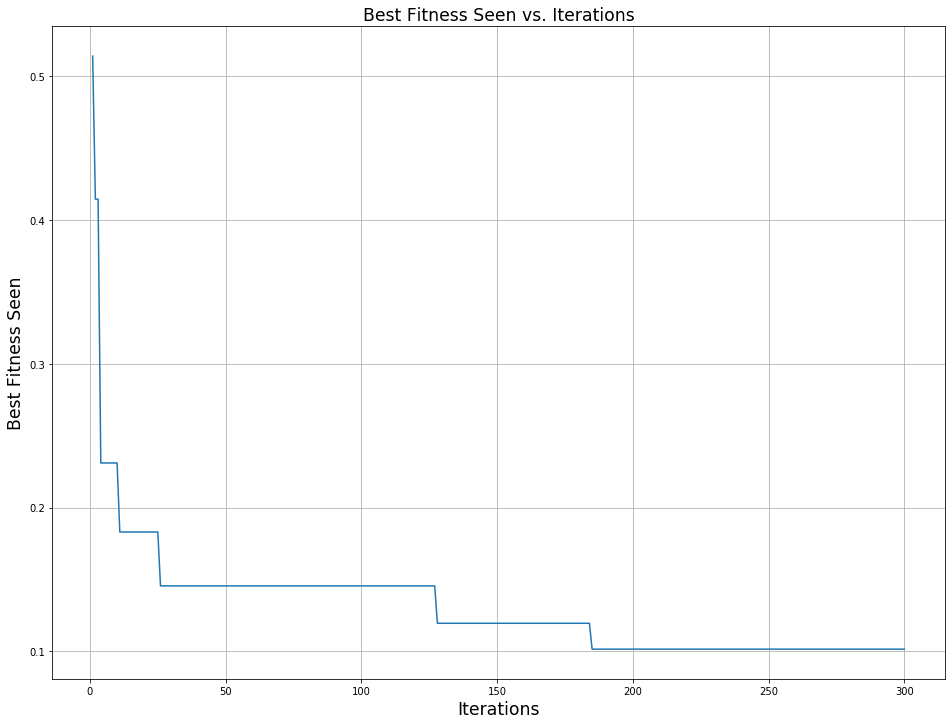

In [108]:
# Plot best ever objective function value seen against iterations
plt.figure(figsize=(16, 12))
plt.title('Best Fitness Seen vs. Iterations', fontsize=fs)
plt.xlabel('Iterations', fontsize=fs)
plt.ylabel('Best Fitness Seen', fontsize=fs)
plt.plot(idxs[:300], bestever[:300])
plt.grid()
plt.savefig('./best_fitness_iterations.png')
plt.show()

In [15]:
best_geno = es.result.xbest
best_t, best_e = geno_to_pheno(best_geno)
print(f'Transmission Matrix:\n{best_t}')
print(f'Emission Matrix:\n{best_e}\n')

best_hmm = hmm.HMM(
    true_x,
    true_y,
    best_t,
    best_e,
    true_s
)

best_hmm2= hmm2(
    true_x2,
    true_y2,
    np.matrix(true_s),
    np.matrix(best_t),
    np.matrix(best_e)
)

seq_len = 10

print('True:')
_, true_seq = true_hmm.simulate(seq_len, reset_before=True)
print(true_seq)

print('Best Found:')
best_states, best_seq = best_hmm.simulate(seq_len, reset_before=True)
print(best_seq)

print('\nFwd:')
print(true_hmm.fwd(best_states, best_seq))
print(best_hmm.fwd(best_states, best_seq))
print(best_hmm2.forward_algo(best_seq))

Transmission Matrix:
[[0.35228093 0.64771907]
 [0.37253848 0.62746152]]
Emission Matrix:
[[0.32358035 0.67641965]
 [0.51400849 0.48599151]]

True:
['b' 'b' 'a' 'a' 'b' 'b' 'b' 'a' 'b' 'b']
Best Found:
['b' 'b' 'a' 'a' 'b' 'a' 'b' 'a' 'a' 'b']

Fwd:
0.0014889422264381445
0.0011151802278446244
0.0011151802278446244


In [16]:
random_a = np.random.dirichlet((2, 1), 2)
random_b = np.random.dirichlet((2, 1), 2)

test_hmm2 = hmm2(
    true_x2,
    true_y2,
    np.matrix(true_s),
    np.matrix(random_a),
    np.matrix(random_b)
)

seq_len = 10
_, test_true_seq = true_hmm.simulate(seq_len, reset_before=True)

e, t, s = test_hmm2.train_hmm([test_true_seq], 1000, [1])

print(s)
print(t)
print(e)

print(true_hmm.fwd(_, test_true_seq))
print(test_hmm2.forward_algo(test_true_seq))

[[1. 0.]]
[[0.25996181 0.74003819]
 [0.81342228 0.18657772]]
[[0.07679258 0.92320742]
 [0.1289233  0.8710767 ]]
0.0022617182385418254
0.038565855586197725


In [ ]:
# Forward algorithm as objective function
def fwd_obj(solution):
    (trans_mat, emiss_mat) = geno_to_pheno(solution)
    sol_hmm = hmm.HMM(
        true_x,
        true_y,
        trans_mat,
        emiss_mat,
        true_s
    )
    
    seq_len = 5
    samples = 20
    ps = np.zeros(samples)
    
    for i in range(samples):
#         print(f'Fitness sample {i}')
        (true_states, true_symbols) = np.array(list(true_hmm.simulate(seq_len, reset_before=True)))

        # Calculate probability, p, of the sequence true_symbols occurring given the HMM parameters in sol_hmm
        p = sol_hmm.fwd(true_states, true_symbols)
        ps[i] = p
    
    # Fitness is minimised
    fitness = 1 - ps.mean() - 0.5
    
#     fitness = (np.square(np.subtract(sol_seq_counts, true_seq_counts))).mean() / seq_len
    print(f'Fitness: {fitness}')
    
    return fitness

In [ ]:
init_sol_2 = np.full(NUM_STATES ** 2 + NUM_STATES * NUM_SYMBOLS, 0.5)
print(init_sol_2)
es_2 = cma.CMAEvolutionStrategy(init_sol_2, 0.1)

In [ ]:
with EvalParallel2(fwd_obj, 4) as eval_all:
    while not es_2.stop():
        solutions = es_2.ask()
#         es_2.tell(solutions, [fwd_obj(x) for x in solutions])
        es_2.tell(solutions, eval_all(solutions))
        es_2.logger.add()  # write data to disc to be plotted
        es_2.disp()

In [ ]:
es_2.result_pretty()

In [ ]:
es_2.logger.plot()

In [ ]:
es_2.logger.plot_divers()

In [ ]:
t, e = geno_to_pheno(es_2.result.xbest)
print(t)
print(e)

In [ ]:
best_geno_2 = es_2.result.xbest
best_t_2, best_e_2 = geno_to_pheno(best_geno_2)
print(f'Transmission Matrix:\n{best_t_2}')
print(f'Emission Matrix:\n{best_e_2}\n')

best_2_hmm = hmm.HMM(
    true_x,
    true_y,
    best_t_2,
    best_e_2,
    true_s
)

seq_len = 5

print('True:')
_, true_seq = true_hmm.simulate(seq_len, reset_before=True)
print(true_seq)

print('Best Found:')
best_states, best_seq = best_2_hmm.simulate(seq_len, reset_before=True)
print(best_seq)

print('\nFwd:')
print(true_hmm.fwd(best_states, best_seq))
print(best_2_hmm.fwd(best_states, best_seq))